# Sampling Decayed Positrons Distribution from Michel Spectrum

In [2]:
import os,shutil
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/00


In [3]:
# setting
MAX_LOOP=100000 # the number of sample you want
data_path = './data'

if os.path.isdir(data_path):
    shutil.rmtree(data_path)
    os.mkdir(data_path)

else:
    os.mkdir(data_path)

# 0.0 initialize constants and variables for calculations

In [2]:
# global constants
EMMU = 105.6 # mass of muon [MeV] (from PDG)
EMASS = 0.511 # mass of positron [MeV] 
pi = np.pi
twopi = 2*pi
fine_structure_const = 1/137

# michel parameters
michel_rho   = 0.75 # Standard Model Michel rho
michel_delta = 0.75 # Standard Model Michel delta
michel_xsi   = 1.00 # Standard Model Michel xsi
michel_eta   = 0.00 # Standard Model eta

# constants in michel sampling
W_mue  = (EMMU*EMMU+EMASS*EMASS)/(2.*EMMU) # gives the maximum energy of emitted positron (52.8 MeV), neglecting neutrino mass
x0     =  EMASS/W_mue
x0_squared = x0*x0

# variables during michel sampling
rndm =0 # just initialize a random variable
x =0
ctheta =0
FG = 0
FG_max = 2.00

# 0.1 Codes for Radiative Corrections

In [3]:
# radiative correction codes from geant4
# https://gitlab.cern.ch/geant4/geant4/-/blob/master/source/particles/management/include/G4MuonDecayChannelWithSpin.hh
# https://gitlab.cern.ch/geant4/geant4/-/blob/master/source/externals/clhep/include/CLHEP/Units/PhysicalConstants.h

def F_c(x,x0,omega):
    f_c =0;
    f_c = (5.+17.*x-34.*x*x)*(omega+np.log(x))-22.*x+34.*x*x;
    f_c = (1.-x)/(3.*x*x)*f_c;
    f_c = (6.-4.*x)*R_c(x,omega)+(6.-6.*x)*np.log(x) + f_c;
    f_c = (fine_structure_const/twopi) * (x*x-x0*x0) * f_c;

    return f_c;

def F_theta(x,x0, omega):
    f_theta=0;

    f_theta = (1.+x+34*x*x)*(omega+np.log(x))+3.-7.*x-32.*x*x;
    f_theta = f_theta + ((4.*(1.-x)*(1.-x))/x)*np.log(1.-x);
    f_theta = (1.-x)/(3.*x*x) * f_theta;
    f_theta = (2.-4.*x)*R_c(x,omega)+(2.-6.*x)*np.log(x)-f_theta;
    f_theta = (fine_structure_const/twopi) * (x*x-x0*x0) * f_theta;

    return f_theta;

def R_c(x,omega):
    n_max = int(100.*x);

    if(n_max<10):n_max=10;

    L2 = 0.0;

    for n in range(n_max+1)[1:]:
        L2 += pow(x,n)/(n*n);

    r_c=0.0;

    r_c = 2.*L2-(pi*pi/3.)-2.;
    r_c = r_c + omega * (1.5+2.*np.log((1.-x)/x));
    r_c = r_c - np.log(x)*(2.*np.log(x)-1.);
    r_c = r_c + (3.*np.log(x)-1.-1./x)*np.log(1.-x);

    return r_c;

# 0.2 Codes for Lorentz Boost

In [14]:
def Lorentz_Boost(x_0,x_1,x_2,x_3,gamma,beta1,beta2,beta3,inverse=False):
    '''
    Implementation of general lorentz boost, from jackson (11.98)
    x is a 4-vector, with components x_0, x_1, x_2, x_3 (minkowski notation with 0,1,2,3 represent ct,x,y,z)
    x can be in K or K' frame, the inverse parameter will take care the correct transformation
    beta1, beta2, beta3 are the components of the velocity of the moving frame K' (K and K' axes are taken to be all parallel to each other)
    
    '''

    if(inverse==True):    # invserse transformation from K' back to K (lab), beta changes sign
        beta1 = -beta1
        beta2 = -beta2
        beta3 = -beta3

    beta_squared = (gamma*gamma - 1) / (gamma*gamma)
        
    #calculate all matrix element of the transformation
    B_00 = gamma

    B_01 = -gamma*beta1

    B_02 = -gamma*beta2

    B_03 = -gamma*beta3


    B_10 = -gamma*beta1

    B_11 = 1+(gamma-1)*(beta1*beta1)/(beta_squared)

    B_12 = (gamma-1)*(beta1*beta2)/(beta_squared)

    B_13 = (gamma-1)*(beta1*beta3)/(beta_squared)


    B_20 = -gamma*beta2

    B_21 = (gamma-1)*(beta2*beta1)/(beta_squared)

    B_22 = 1+(gamma-1)*(beta2*beta2)/(beta_squared)

    B_23 = (gamma-1)*(beta2*beta3)/(beta_squared)


    B_30 = -gamma*beta3

    B_31 = (gamma-1)*(beta3*beta1)/(beta_squared)

    B_32 = (gamma-1)*(beta3*beta2)/(beta_squared)

    B_33 = 1+(gamma-1)*(beta3*beta3)/(beta_squared)


    # calculate the results
    x0_transformed = B_00*x_0 + B_01*x_1 + B_02*x_2 + B_03*x_3

    x1_transformed = B_10*x_0 + B_11*x_1 + B_12*x_2 + B_13*x_3

    x2_transformed = B_20*x_0 + B_21*x_1 + B_22*x_2 + B_23*x_3

    x3_transformed = B_30*x_0 + B_31*x_1 + B_32*x_2 + B_33*x_3

    return [x0_transformed, x1_transformed, x2_transformed, x3_transformed]

# 0.3 Codes for Calculating g2 Phase

In [15]:
def Calculate_Phase(y1, x1, y2, x2):
   # compute the angle difference between vector1 and vector2 given their x,y components. */
   
    ans1 = np.arctan2(y1,x1);  # angle of vector 1, muDecayP
    ans2 = np.arctan2(y2,x2);  # angle of vector 2, muDecayPol
    ans = ans1 - ans2;

    if(ans<0):
        ans = ans+2*np.pi;

    return ans;

# 0.4 Initialize arrays to store data
# ...

# 1.0 Sample the michel distribution of positrons (in the muon frame) over $x$ and $\theta$ by accept-or-reject method

general michel parameters:

https://en.wikipedia.org/wiki/Michel_parameters

measuring michel parameters (TWIST)

https://sci-hub.mksa.top/10.1103/PhysRevLett.106.041804

https://slidetodoc.com/measuring-muon-decay-with-twist-glen-marshall-for/


michel sampling implementation in geant 4:

https://gitlab.cern.ch/geant4/geant4/-/blob/master/source/particles/management/src/G4MuonDecayChannelWithSpin.cc

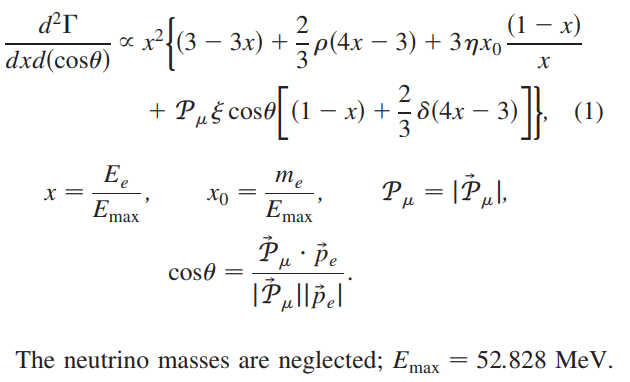image.png](attachment:00284a3e-1d7a-4a0d-9605-61039f735c5a.png)

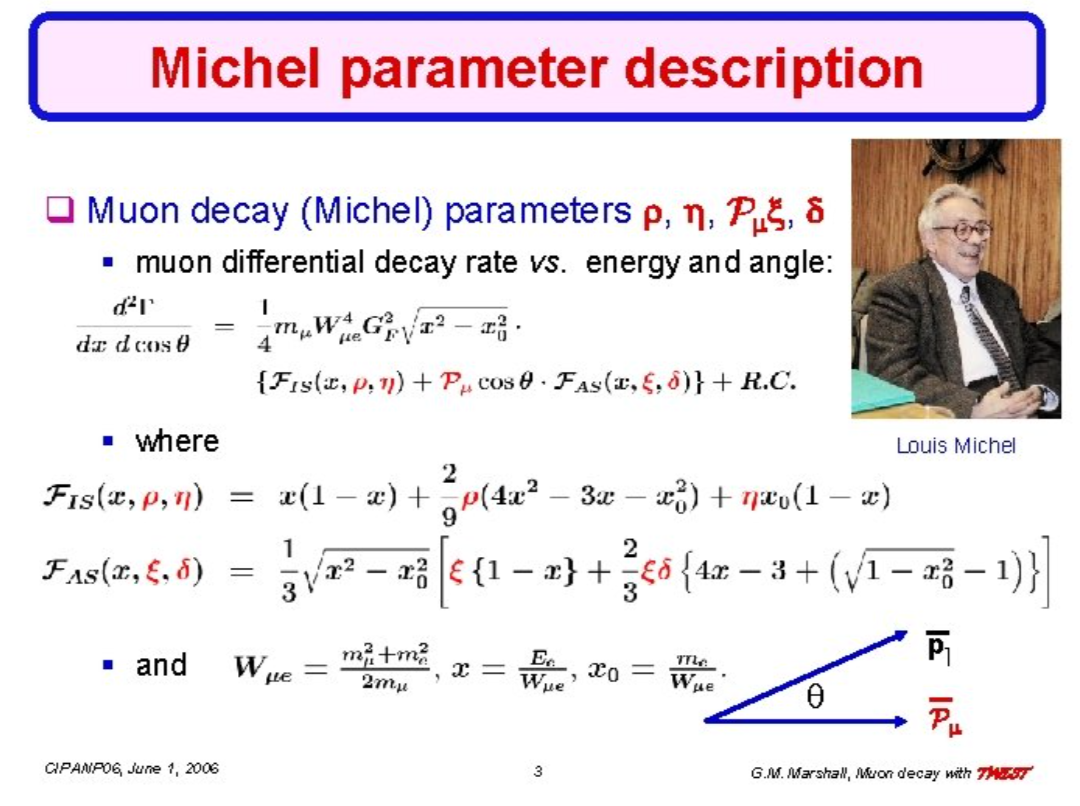
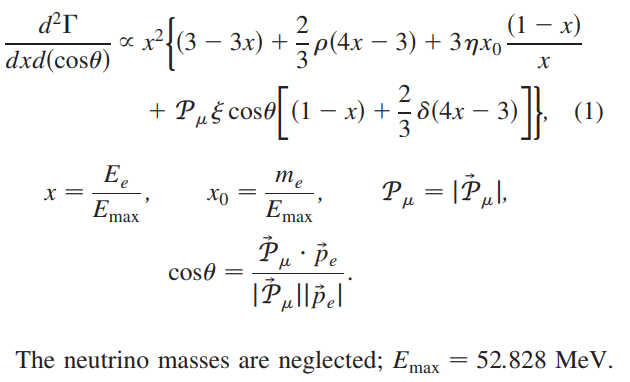

In [4]:
#   // code adapted from geant4 
#   // ***************************************************
#   //     x0 <= x <= 1.   and   -1 <= y <= 1
#   //
#   //     F(x,y) = f(x)*g(x,y);   g(x,y) = 1.+g(x)*y
#   // ***************************************************

#   // ***** sampling F(x,y) directly (brute force) *****

# sampling parameters
Michel_Samples = np.zeros(shape=(MAX_LOOP,2)) # store samples

count = 0 # keep track of the accumulated samples

while (count<MAX_LOOP):
    rndm = np.random.uniform(0,1);

    x = x0 + rndm*(1.-x0); # throw out a guess for x
    
    x_squared = x*x;

    F_IS=0; F_AS=0; G_IS=0; G_AS=0
    
    F_IS = 1./6.*(-2.*x_squared+3.*x-x0_squared);
    F_AS = 1./6.*np.sqrt(x_squared-x0_squared)*(2.*x-2.+np.sqrt(1.-x0_squared));

    G_IS = 2./9.*(michel_rho-0.75)*(4.*x_squared-3.*x-x0_squared);
    G_IS = G_IS + michel_eta*(1.-x)*x0;

    G_AS = 3.*(michel_xsi-1.)*(1.-x);
    G_AS = G_AS+2.*(michel_xsi*michel_delta-0.75)*(4.*x-4.+np.sqrt(1.-x0_squared));
    G_AS = 1./9.*np.sqrt(x_squared-x0_squared)*G_AS;

    F_IS = F_IS + G_IS;
    F_AS = F_AS + G_AS;

# / *** Radiative Corrections ***
    omega =  np.log(EMMU/EMASS);
    R_IS = F_c(x,x0,omega);

    F = 6.*F_IS + R_IS/np.sqrt(x_squared-x0_squared);

# // *** Radiative Corrections ***

    R_AS = F_theta(x,x0,omega);

    rndm = np.random.uniform(0,1);

    ctheta = 2.*rndm-1.; # throw out a guess for theta (cosine of angle between spin and momentum of positron, range from -1 to 1)

    G = 6.*F_AS - R_AS/np.sqrt(x_squared-x0_squared);
    

# combine separate parts

    FG = np.sqrt(x_squared-x0_squared)*F*(1.+(G/F)*ctheta);

    if(FG>FG_max):
        Print("G4MuonDecayChannelWithSpin::DecayIt()","PART113", "JustWarning, Problem in Muon Decay: FG > FG_max");
        FG_max = FG;

    rndm = np.random.uniform(0,1); # throw out a guess for THOR

    if (FG >= rndm*FG_max): # points ?? above ?? the surface of distribution get sampled ?????????????
        Michel_Samples[count,0] = x # store E/EMAX
        Michel_Samples[count,1] = ctheta # store cos(theta)
        count += 1


In [5]:
fname = os.path.join(data_path,'01_michel_samples_10M.npy')
# np.save(fname,Michel_Samples)

./data/michel_samples_10M.npy


# 2.0 sampling positron 3-momentum (in Muon rest frame)

<p style="color:red;">try the easy one: used theta (from Michel) and random phi to fix positron momentum</p>

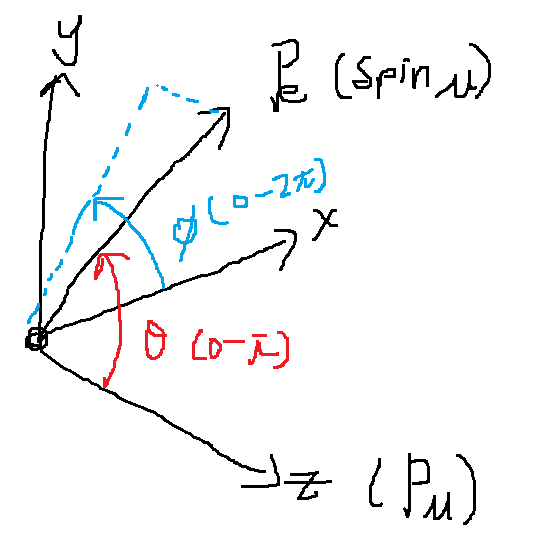

<p style="color:red;">this get you px,py,pz</p>

<p style="color:red;">boost in pz direction, and recalculate the Energy, to get 4-momenta in LAB</p>

<p style="color:red;">*** Warning, pz is in local coordinate, but can easily transformed to ring coordinates by rotating x,y plane</p>

In [10]:
# https://gitlab.cern.ch/geant4/geant4/-/blob/master/source/externals/clhep/include/CLHEP/Vector/LorentzVector.h
four_momenta_mu_frame = np.zeros(shape=(MAX_LOOP,6)) # store posiInitE, posiInitPX, posiInitPY ,posiInitPZ (in MRF)

for i in range(MAX_LOOP):
    energy = Michel_Samples[i,0]*W_mue
    if(energy < EMASS):energy = EMASS;
    
    three_momentum = np.sqrt(energy*energy - EMASS*EMASS);
    
    # retrieve E,theta from Michel spectrum
    ctheta = Michel_Samples[i,1]
    stheta = np.sqrt(1.-ctheta*ctheta);
    
    rndm = np.random.uniform(0,1) # generate a random angle phi to fix muon momentum in x,y,z
    phi = twopi * rndm;
    cphi = np.cos(phi);
    sphi = np.sin(phi);
    
    # momentum of the decay positron with respect to the muon spin
    px0 = stheta*cphi*three_momentum ;
    py0 = stheta*sphi*three_momentum ;
    pz0 = ctheta*three_momentum ;
    
    # introduce aritificial spin precession
    rndm = np.random.uniform(0,1)
    alpha= twopi * rndm;
    calpha = np.cos(alpha); # muDecayPolZ i not yet understand, but polarization involve counting, so it is lorentz transformed into itself
    salpha = np.sin(alpha); # muDecayPolX ref: https://arxiv.org/pdf/hep-ph/0409166.pdf
    
    # rotate px py pz wrt 'new' spin direction
    px = calpha*px0 + salpha*pz0
    py = py0
    pz = -salpha*px0 + calpha*pz0
    
    four_momenta_mu_frame[i,0] = energy
    four_momenta_mu_frame[i,1] = px
    four_momenta_mu_frame[i,2] = py
    four_momenta_mu_frame[i,3] = pz
    four_momenta_mu_frame[i,4] = salpha # muDecayPolX
    four_momenta_mu_frame[i,5] = calpha # muDecayPolZ

In [ ]:
fname = os.path.join(data_path,'02_four_momenta_MRF_10M.npy')
# np.save(fname,four_momenta_mu_frame)

# 3.0 lorentz boost in pz direction (to LAB frame)

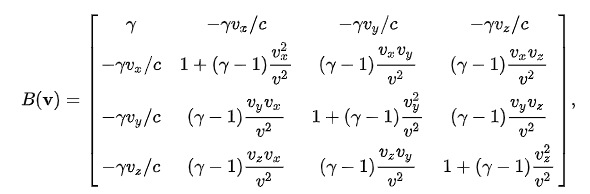

In [16]:
# lorentz boost parameter (in gm2 experiment)
p_mu_magic = 3.1 # GeV/c (PRL)
gamma_mu = 29.3 # (PRL)
beta_mu_squared = 1-(1/gamma_mu)*(1/gamma_mu) # check the redundancy !
beta_mu = np.sqrt(beta_mu_squared) # calculated from gamma_mu
gamma_tau_mu = 64.4e-6 # sec (PRD)

four_momenta_LAB = np.zeros(shape=(MAX_LOOP,10)) # store the final posiInitE, posiInitPX , posiInitPY, posiInitPZ, cos(angle of z-axis with muon momentum)
# copy the values from previos step
four_momenta_LAB[:,6] = four_momenta_mu_frame[:,4] # muDecayPolZ
four_momenta_LAB[:,7] = four_momenta_mu_frame[:,5] # muDecayPolX  


for i in range(MAX_LOOP):
    # introduce artificial cyclotron motion for muon (using random number to test)
    rndm = np.random.uniform(0,1)
    rot = twopi * rndm;
    crot = np.cos(rot);
    srot = np.sin(rot);
    
    # calculate the velocity components of muon frame in LAB frame
    beta_mu_z = beta_mu*crot
    beta_mu_x = beta_mu*srot
    
    # get 4-momenta in MRF and boost to LAB frame
    E_primed  = four_momenta_mu_frame[i,0] # PosiInitE
    px_primed = four_momenta_mu_frame[i,1] # PosiInitPX
    py_primed = four_momenta_mu_frame[i,2] # PosiInitPY
    pz_primed = four_momenta_mu_frame[i,3] # PosiInitPZ
    
    # lorentz boost
    PosiInitE,PosiInitPX,PosiInitPY,PosiInitPZ= Lorentz_Boost(E_primed,px_primed,py_primed,pz_primed,gamma_mu,beta_mu_x,0,beta_mu_z,inverse=True) 
    four_momenta_LAB[i,0] = PosiInitE
    four_momenta_LAB[i,1] = PosiInitPX
    four_momenta_LAB[i,2] = PosiInitPY
    four_momenta_LAB[i,3] = PosiInitPZ
    
    four_momenta_LAB[i,4] = beta_mu_x # related to muDecayPX
    four_momenta_LAB[i,5] = beta_mu_z # related to muDecayPZ
    
    # calculate g2phase "Phase(muDecayPX,muDecayPZ,muDecayPolX,muDecayPolZ)"
    phase = Calculate_Phase(four_momenta_LAB[i,4], four_momenta_LAB[i,5],
                            four_momenta_LAB[i,6], four_momenta_LAB[i,7])
    four_momenta_LAB[i,8] = phase # g2phase
    four_momenta_LAB[i,9] = np.cos(phase) # cos(g2phase)  

In [ ]:
fname = os.path.join(data_path,'03_four_momenta_LAB_10M.npy')
# np.save(fname,four_momenta_LAB)